In [ ]:
!wget https://s3-ap-southeast-1.amazonaws.com/he-public-data/datasetb2d9982.zip

--2023-04-22 05:44:42--  https://s3-ap-southeast-1.amazonaws.com/he-public-data/datasetb2d9982.zip
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.36.250
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.36.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 895569552 (854M) [binary/octet-stream]
Saving to: ‘datasetb2d9982.zip.1’

datasetb2d9982.zip. 100%[===================>] 854.08M  18.8MB/s    in 48s     

2023-04-22 05:45:30 (17.9 MB/s) - ‘datasetb2d9982.zip.1’ saved [895569552/895569552]



In [ ]:
!unzip /content/datasetb2d9982.zip -d data

Archive:  /content/datasetb2d9982.zip
replace data/dataset/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/dataset/sample_submission.csv  
replace data/dataset/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/dataset/train.csv  y
y

replace data/dataset/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/dataset/test.csv   y



In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import csv
import os
import random
import torch
import torch
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
import sklearn.model_selection as model_selection
from transformers import BertForSequenceClassification, BertTokenizerFast
import time
import copy
from tqdm.notebook import tqdm

In [ ]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
df=pd.read_csv("/content/data/dataset/train.csv")

In [ ]:
df.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000


In [ ]:
##Take TITLE+BULLET_POINTS+DESCRIPTION+ID Combine and get product lenght
df["PRODUCT_ID"].unique()

array([1925202, 2673191, 2765088, ..., 1987786, 1165754, 1072666])

In [ ]:
len(df["PRODUCT_TYPE_ID"].unique())

12907

In [ ]:
sample_submission = pd.read_csv("/content/data/dataset/sample_submission.csv")

In [ ]:
sample_submission.head()

,PRODUCT_ID,PRODUCT_LENGTH
0,604373,701.093794
1,1729783,734.506163
2,1871949,741.360258
3,1107571,730.327767
4,624253,666.847946


In [ ]:
df = df.drop(['PRODUCT_ID'], axis=1)
df = df.drop(['PRODUCT_TYPE_ID'], axis=1)
#df.drop(['PRODUCT_TYPE_ID'], axis=1)

In [ ]:
num_labels=df["PRODUCT_LENGTH"].nunique()

In [ ]:
num_labels

16655

In [ ]:
id2lbl={lbl: idx for idx,lbl in enumerate(list(df["PRODUCT_LENGTH"].unique()))}
lbl2id={lbl:idx for idx,lbl in id2lbl.items()}

In [ ]:
set_seed()

In [ ]:
df["PRODUCT_LENGTH"]=df["PRODUCT_LENGTH"].map(id2lbl)

In [ ]:
def create_folds(data, num_splits):
    data["kfold"] = -1
    data = data.sample(frac=1).reset_index(drop=True)
    y=df["PRODUCT_LENGTH"]
    kf = model_selection.StratifiedKFold(n_splits=num_splits)
    for f, (t_, v_) in enumerate(kf.split(X=data, y=y)):
        data.loc[v_, 'kfold'] = f
    return data

In [ ]:
df=create_folds(df, 5)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
df=df.loc[df.kfold.isin([0,2])]
df=df.reset_index(drop=True)
df.head()

,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_LENGTH,kfold
0,Calendrier sacre maya 2005-2006,NaN,NaN,436,0
1,Fractured Reality,NaN,NaN,17,0
2,The Golden Butterfly the most daring illusion ...,The Golden Butterfly the most daring illusion ...,NaN,479,0
3,10x30 Contemporary Bronze Complete Wood Panora...,[&#11088; COMPLETE WOOD PICTURE FRAME: Bronze ...,COMPLETE WOOD PICTURE FRAME Made To Display Ph...,1116,0
4,"Quality By Experimental Design, 3rd Edition (Q...",NaN,NaN,34,0


In [ ]:
df["kfold"].unique()

array([0, 2])

In [ ]:
df.loc[df['PRODUCT_LENGTH']==436	].head()

,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_LENGTH,kfold
0,Calendrier sacre maya 2005-2006,NaN,NaN,436,0
2560,Autofetch Petrol Inside Decal/Sticker Car Fuel...,[Vehicle Compatibility: Universal for all Car ...,Autofetch Petrol Inside Decal/Sticker Car Fuel...,436,0
3138,Lire philippe muray essais,NaN,NaN,436,0
3282,Arvesa Influence of a Great Teacher Can Never ...,[High quality mug makes the perfect gift for e...,Great gift idea This is a mug that somebody wo...,436,0
6219,Crassula 12 in 1 Vegetable and Fruit Cutter Ch...,[Material: High-quality stainless steel blades...,GYANVI VEGETABLE & FRUIT CHOPPER: ➤Easy to mak...,436,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899880 entries, 0 to 899879
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   TITLE           899877 non-null  object
 1   BULLET_POINTS   564971 non-null  object
 2   DESCRIPTION     437021 non-null  object
 3   PRODUCT_LENGTH  899880 non-null  int64 
 4   kfold           899880 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 34.3+ MB


In [ ]:
df.isnull().sum()

TITLE                  3
BULLET_POINTS     334909
DESCRIPTION       462859
PRODUCT_LENGTH         0
kfold                  0
dtype: int64

In [ ]:
temp=df.dropna(subset=['TITLE'])
temp=temp.reset_index(drop=True)

In [ ]:
temp.isnull().sum()

TITLE                  0
BULLET_POINTS     334906
DESCRIPTION       462856
PRODUCT_LENGTH         0
kfold                  0
dtype: int64

In [ ]:
total_words=0
for title in temp['TITLE']:
    total_words+=len(title.split())

In [ ]:
total_words/len(temp)

13.57212263453783

In [ ]:
temp=df.dropna(subset=['DESCRIPTION'])
total_words=0
for title in temp['DESCRIPTION']:
    total_words+=len(title.split())
total_words/len(temp)

96.89719258342276

In [ ]:
temp=df.dropna(subset=['TITLE'])
temp=temp.fillna(" ")

In [ ]:
temp.head()

,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_LENGTH,kfold
0,Calendrier sacre maya 2005-2006,,,436,0
1,Fractured Reality,,,17,0
2,The Golden Butterfly the most daring illusion ...,The Golden Butterfly the most daring illusion ...,,479,0
3,10x30 Contemporary Bronze Complete Wood Panora...,[&#11088; COMPLETE WOOD PICTURE FRAME: Bronze ...,COMPLETE WOOD PICTURE FRAME Made To Display Ph...,1116,0
4,"Quality By Experimental Design, 3rd Edition (Q...",,,34,0


In [ ]:
" ".join(temp["BULLET_POINTS"][2].split(","))[:-1][1:]

'he Golden Butterfly the most daring illusion of the age - performend by Harry (Heinrich) Keller (1849-1922) He was a predecessor to Houdini and was considered the dean of American magicians When he retired he gave his tricks to Howard Thurston in 1908 He was most famous for the levitating woma'

In [ ]:
df.head()

,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_LENGTH,kfold
0,Calendrier sacre maya 2005-2006,NaN,NaN,436,0
1,Fractured Reality,NaN,NaN,17,0
2,The Golden Butterfly the most daring illusion ...,The Golden Butterfly the most daring illusion ...,NaN,479,0
3,10x30 Contemporary Bronze Complete Wood Panora...,[&#11088; COMPLETE WOOD PICTURE FRAME: Bronze ...,COMPLETE WOOD PICTURE FRAME Made To Display Ph...,1116,0
4,"Quality By Experimental Design, 3rd Edition (Q...",NaN,NaN,34,0


In [ ]:
wholeSentence=[]
for idx,row in temp.iterrows(): 
    if(idx%100000==0):
        print(f"{idx} Done")
    wholeSentence.append(row[0]+row[1]+" ".join(row[2].split(","))[:-1][1:])

0 Done
100000 Done
200000 Done
300000 Done
400000 Done
500000 Done
600000 Done
700000 Done
800000 Done


In [ ]:
temp["WHOLE SENTENCE"]=wholeSentence

In [ ]:
temp=temp.reset_index(drop=True)

In [ ]:
temp.head()

,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_LENGTH,kfold,WHOLE SENTENCE
0,Calendrier sacre maya 2005-2006,,,436,0,Calendrier sacre maya 2005-2006
1,Fractured Reality,,,17,0,Fractured Reality
2,The Golden Butterfly the most daring illusion ...,The Golden Butterfly the most daring illusion ...,,479,0,The Golden Butterfly the most daring illusion ...
3,10x30 Contemporary Bronze Complete Wood Panora...,[&#11088; COMPLETE WOOD PICTURE FRAME: Bronze ...,COMPLETE WOOD PICTURE FRAME Made To Display Ph...,1116,0,10x30 Contemporary Bronze Complete Wood Panora...
4,"Quality By Experimental Design, 3rd Edition (Q...",,,34,0,"Quality By Experimental Design, 3rd Edition (Q..."


In [ ]:
temp["WHOLE SENTENCE"][67]

'Flash Furniture Specter Series Transparent Stacking Side Chair[Stackable Accent Chair,Stack Quantity: 4,Transparent Crystal Finish,Artistic Design,Polycarbonate Molded Structure]'

In [ ]:
dev=torch.device('cuda')

In [ ]:
dev

device(type='cuda')

In [ ]:
temp["PRODUCT_LENGTH"].value_counts()

12       53033
9        32163
17       25002
8        23281
81       17934
         ...  
5268         1
9143         1
5346         1
8702         1
10460        1
Name: PRODUCT_LENGTH, Length: 10859, dtype: int64

In [ ]:
train_text, val_text, train_labels, val_labels = train_test_split(temp['WHOLE SENTENCE'], temp["PRODUCT_LENGTH"],
                                                                    test_size=0.05)

In [ ]:
train_text=train_text.reset_index(drop=True)
train_labels=train_labels.reset_index(drop=True)
val_text=val_text.reset_index(drop=True)
val_labels=val_labels.reset_index(drop=True)

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

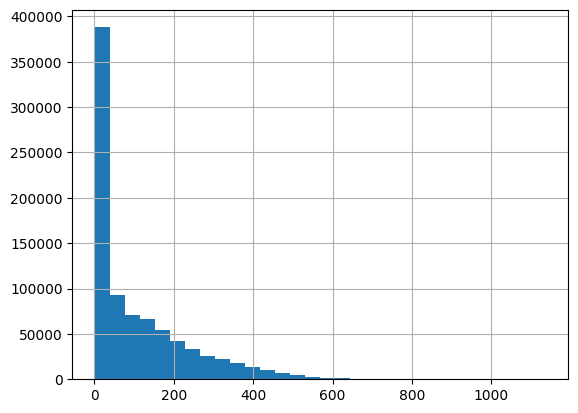

In [ ]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 64

In [ ]:
class amazonDataset(Dataset):
  def __init__(self,text,label,tokenizer):
    self.sentence=text
    self.label=label
    self.tokenizer=tokenizer

  def __len__(self):
    return len(self.sentence)
  
  def __getitem__(self,idx):
    inp_tokens=self.tokenizer.encode_plus(self.sentence[idx], 
                                          padding="max_length", 
                                          add_special_tokens=True,
                                          max_length=max_seq_len, 
                                          truncation=True)
    inp_id=inp_tokens.input_ids
    inp_mask=inp_tokens.attention_mask
    inp_type_ids=inp_tokens.token_type_ids
    labels=self.label[idx]

    return {
#         "text":self.sentence,
        "input_ids":torch.tensor(inp_id, dtype=torch.long),
        "input_attention_mask":torch.tensor(inp_mask, dtype=torch.long),
        "input_type_ids":torch.tensor(inp_type_ids, dtype=torch.long),
        "labels":torch.tensor(labels, dtype=torch.float)
    }

In [ ]:
train_dataset = amazonDataset(train_text, train_labels, tokenizer)
val_dataset = amazonDataset(val_text, val_labels, tokenizer)

In [ ]:
train_dataloader=DataLoader(train_dataset,
                            batch_size=128,
                            shuffle=True,
                            num_workers=2,
                           pin_memory=True)
val_dataloader=DataLoader(val_dataset,
                            batch_size=128,
                            shuffle=False,
                            num_workers=2,
                            pin_memory=True)

In [ ]:
dataloaders={'train':train_dataloader, 'eval':val_dataloader }
dataset_sizes={'train':len(train_dataset), 'eval':len(val_dataset)}

In [ ]:
model=BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=16655)
print(model)
# model=torch.load("/content/pytorch_model.bin")
model.to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
def train_fn(model,loss_fn,optimizer,scheduler,num_epochs=1):
    since=time.time()
    best_wts=copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    for epoch in range(num_epochs):
        print(f'Epoch:{epoch}/{num_epochs}')
        print('-'*10)
        
        for mode in ['train','eval']:
            if mode=='train':
                model.train()
            elif mode=='eval':
                model.eval()
            
            running_loss=0.0
            running_corrects=0.0
            
            for data in tqdm(dataloaders[mode]):
                input_ids = data["input_ids"].to(dev, dtype=torch.long)
                labels = data['labels'].to(dev, dtype=torch.long)
                mask = data["input_attention_mask"].to(dev, dtype=torch.long)
                token_type_ids = data['input_type_ids'].to(dev, dtype=torch.long)
            
                optimizer.zero_grad()
                with torch.set_grad_enabled(mode=='train'):
                    outputs=model(
                                input_ids =input_ids,
                                attention_mask=mask,
                                token_type_ids=token_type_ids,
                                labels=labels
                            )
                    loss, logits=outputs.loss, outputs.logits
                    _,preds=torch.max(logits,1)
                    
                    if mode=='train':
                        loss.backward()
                        optimizer.step()                    
                    running_loss += loss.item()                    
                    running_corrects += torch.sum(preds == labels.data)

            if mode == 'train':
                scheduler.step()
                
            epoch_loss=running_loss/dataset_sizes[mode]
            epoch_accuracy=running_corrects.double()/dataset_sizes[mode]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                mode, epoch_loss, epoch_accuracy))
            
            if mode=='eval' and epoch_loss<best_loss:
                best_wts=copy.deepcopy(model.state_dict())
                best_acc=epoch_accuracy
                best_loss=epoch_loss
            
            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val loss: {:4f}'.format(best_loss))
        print('Best val Acc: {:4f}'.format(best_acc))
    
        model.load_state_dict(best_wts)
    return model

In [ ]:
model = train_fn(model, criterion, optimizer, 
               exp_lr_scheduler,
               num_epochs=1)

Epoch:0/1
----------


  0%|          | 0/6679 [00:00<?, ?it/s]

train Loss: 0.0519 Acc: 0.0714



  0%|          | 0/352 [00:00<?, ?it/s]

eval Loss: 0.0472 Acc: 0.0834

Training complete in 146m 22s
Best val loss: 0.047204
Best val Acc: 0.083367


In [ ]:
torch.save(model,"BertBaselineBase.pth")